In [ ]:
import random
from deap import base, creator, tools, algorithms
from autogluon.tabular import TabularDataset, TabularPredictor

# Read the train data from the wine.csv file
train_data = TabularDataset('wine.csv')

# Define the multi-objective optimization problem
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Define the search space (decision variables)
toolbox = base.Toolbox()
toolbox.register("lambda_param", random.uniform, 1e-4, 1e-1)
toolbox.register("min_child_weight", random.uniform, 1, 10)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.lambda_param, toolbox.min_child_weight), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evaluate(individual):
    lambda_param, min_child_weight = individual
    
    # Train and evaluate the AutoGluon model with the given hyperparameters
    hyperparameter_space = {
        'model': 'XGB',
        'hyperparameters': {
            'lambda': lambda_param,
            'min_child_weight': min_child_weight,
        }
    }
    
    predictor = TabularPredictor(label='WineType').fit(train_data, hyperparameters=hyperparameter_space)
    
    # Obtain the model performance metrics
    accuracy = predictor.evaluate(valid_data)['accuracy']
    
    # Objective: Maximize accuracy, Minimize training time (placeholder; you can adjust based on your goals)
    training_time = 1.0
    
    return accuracy, training_time

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Define the optimization algorithm (NSGA-II)
def main():
    pop = toolbox.population(n=50)
    algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.7, mutpb=0.2, ngen=50, stats=None, halloffame=None, verbose=True)

    # Get the best individual(s) found by NSGA-II
    best_individuals = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]

    # Use the best hyperparameters to train the final AutoGluon model
    best_hyperparameters = [indiv[0] for indiv in best_individuals]
    best_hyperparameters = best_hyperparameters[0]  # Assuming only one best individual, you may need to adjust if multiple

    hyperparameter_space = {
        'model': 'XGB',
        'hyperparameters': {
            'lambda': best_hyperparameters[0],
            'min_child_weight': best_hyperparameters[1],
        }
    }

    final_predictor = TabularPredictor(label='WineType').fit(train_data, hyperparameters=hyperparameter_space)
    
    # You can save or use the final_predictor for making predictions on new data
    final_predictions = final_predictor.predict(new_data)

toolbox.register("evaluate", evaluate)


In [ ]:
import random
from deap import base, creator, tools, algorithms
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from autogluon.tabular.models import XGBoostModel
import matplotlib.pyplot as plt

# Read the wine dataset
dataset = TabularDataset('wine.csv')

# Define the features and target column
features = ['alcohol', 'ash', 'proline']
target = 'alcohol'

# Define the standard hyperparameters for AutoGluon
standard_hyperparameters = {
    'model': 'XGB',
    'hyperparameters': {
        'lambda': 1e-4,
        'min_child_weight': 1,
    }
}

# Train the initial AutoGluon model
initial_predictor = TabularPredictor(label=target).fit(dataset, hyperparameters=standard_hyperparameters)

# Run NSGA-II to find the best hyperparameters
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("lambda_param", random.uniform, 1e-4, 1e-1)
toolbox.register("min_child_weight", random.uniform, 1, 10)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.lambda_param, toolbox.min_child_weight), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    lambda_param, min_child_weight = individual
    
    hyperparameters = {
        'model': 'XGB',
        'hyperparameters': {
            'lambda': lambda_param,
            'min_child_weight': min_child_weight,
        }
    }
    
    predictor = TabularPredictor(label=target).fit(dataset, hyperparameters=hyperparameters)
    accuracy = predictor.evaluate(dataset)['accuracy']
    
    training_time = 1.0
    
    return accuracy, training_time

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

def main():
    pop = toolbox.population(n=50)
    TabularPredictor.register_model(model_type='XGB', model=XGBoostModel)

    return initial_predictor, final_predictor

# Register XGBoost as a custom model preset
TabularPredictor.register_model(model_type='XGB', model=XGBoostModel)


gen	nevals
0  	14    
1  	4     
2  	4     
3  	4     
4  	3     
5  	3     
6  	4     
7  	4     
8  	2     
9  	4     
10 	3     
best set of hyperparameters [[53, 2, 5.522704080144341], [41.00550601172351, 6.05500898674777, 5.992357644245458], [58.16496668715854, 7.0, 5.839734318416498], [58.16496668715854, 7.0, 5.504427542080415], [45.8108522349238, 9.251201308574952, 4.700737531682407], [48.49686647146194, 7.0, 8.447832280608718], [99, 6.237848392855884, 5.755640643340085], [54, 7, 9.593054532461913], [54, 7, 9.593054532461913], [126.60168247443265, 6.738674935801717, 5.322313010953151], [54.1491965852328, -1.3542075617132268, 9.478257947932454], [40, 7, 4.273269444138878], [76, 10, 0.8039777921179652], [91.44994121909448, 7.534851557006977, -0.8068012937594]]
best hyperparameters [53, 2, 5.522704080144341]
Best Hyperparameters:
Num Boost Round: 53
Max Depth: 2
Min Child Weight: 5.522704080144341
Best Accuracy: 0.0
Best Macro Average: 0.0


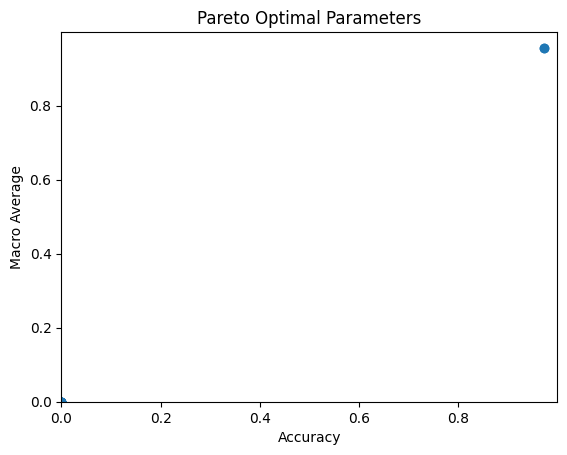

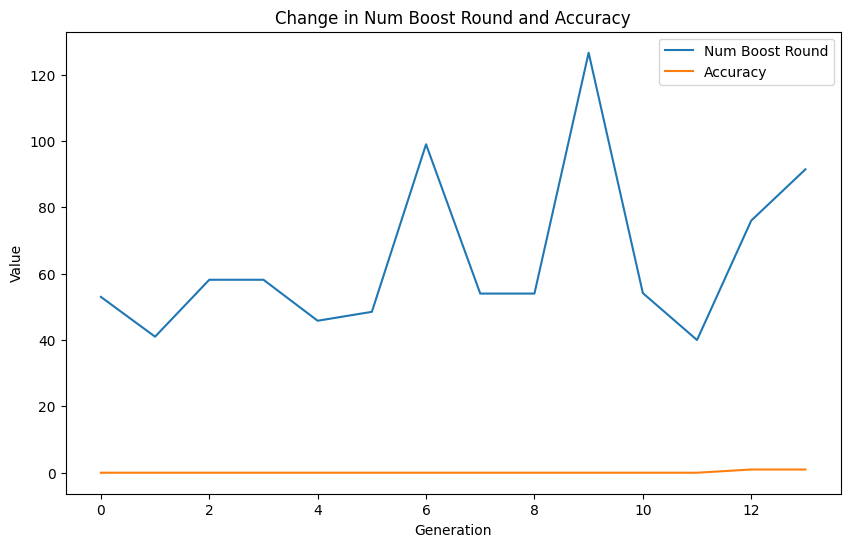

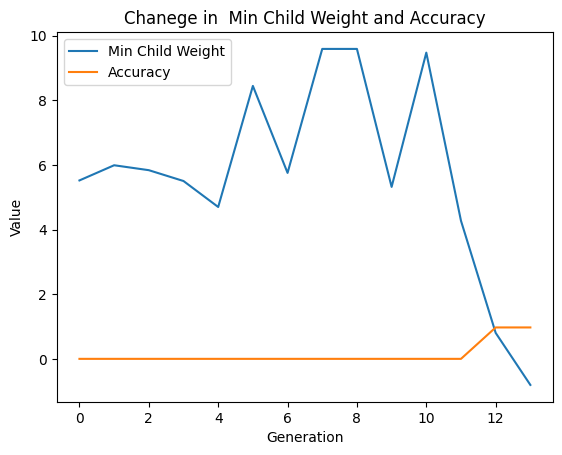

In [18]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import pandas as pd
import numpy as np

# Assuming you have a DataFrame 'df' with columns: 'WineType', 'Alcohol', 'AshAlkalinity', etc.
# Replace 'WineType' with the actual target variable and other columns with your features
df = pd.read_csv('wine.csv')
X = df.drop(columns=['ash', 'proline'])
y = df['alcohol']

# Convert the target variable to integer type
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function
def evaluate(individual):
    num_boost_round, max_depth, min_child_weight = individual
    min_child_weight = max(0.0000000001, min_child_weight)  # Ensure min_child_weight is greater than or equal to 0
    num_boost_round = int(num_boost_round)
    max_depth = max(0,int(max_depth))  # XGBoost requires integer values for these parameters
    # Define XGBoost hyperparameters
    params = {
        'objective': 'multi:softmax',  # Example: For multiclass classification
        'num_class': 178,  # Number of classes in your problem
        'booster': 'gbtree',  # 'gbtree' or 'gblinear'
        'lambda': 1,  # Regularization term
        'min_child_weight': int(min_child_weight),  # Minimum sum of instance weight (hessian) needed in a child
        'subsample': 0.8,  # Subsample ratio of the training instance
        'colsample_bylevel': 0.8,  # Subsample ratio of columns for each level
        'colsample_bytree': 0.8,  # Subsample ratio of columns for each tree
        'learning_rate': 0.1,  # Step size shrinkage to prevent overfitting
        'num_boost_round': int(num_boost_round),  # Number of boosting rounds
        'max_depth': int(max_depth),  # Maximum depth of a tree
        # Add more XGBoost parameters as needed
    }

    # ...

    min_child_weight = int(min_child_weight)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)

    # Calculate macro average
    report = classification_report(y_test, y_pred, output_dict=True)
    macro_avg = report['macro avg']['f1-score']

    return accuracy, macro_avg

# Define the optimization problem
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("num_boost_round", random.randint, 1, 100)
toolbox.register("max_depth", random.randint, 1, 10)
toolbox.register("min_child_weight", random.uniform, 1, 10)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.num_boost_round, toolbox.max_depth, toolbox.min_child_weight), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Run the optimization algorithm (NSGA-II)
def main():
    # Suppress runtime warnings and user warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Store the values of num_boost_round, min_child_weight, and accuracy
    num_boost_round_values = []
    min_child_weight_values = []
    accuracy_values = []
    pop = toolbox.population(n=14)
    algorithms.eaMuPlusLambda(pop, toolbox, mu=14, lambda_=4, cxpb=0.7, mutpb=0.2, ngen=10, stats=None, halloffame=None, verbose=True)

    # Get the best individual(s) found by NSGA-II
    best_individuals = tools.sortNondominated(pop, len(pop), first_front_only=False)[0]
    print('best set of hyperparameters',best_individuals)
    for individual in best_individuals:
            num_boost_round_values.append(individual[0])
            min_child_weight_values.append(individual[2])
            accuracy_values.append(evaluate(individual)[0])
    # Extract the hyperparameters of the best individual
    best_hyperparameters = best_individuals[0]
    best_hyperparameters = best_hyperparameters  # Assuming only one best individual, you may need to adjust if multiple
    print('best hyperparameters',best_hyperparameters)
    # Evaluate the best individual
    best_accuracy, best_macro_avg = evaluate(best_hyperparameters)

    # Print the best hyperparameters and their performance
    print("Best Hyperparameters:")
    print("Num Boost Round:", best_hyperparameters[0])
    print("Max Depth:", best_hyperparameters[1])
    print("Min Child Weight:", best_hyperparameters[2])
    print("Best Accuracy:", best_accuracy)
    print("Best Macro Average:", best_macro_avg)

    # Plot the Pareto optimal parameters
    pareto_front = np.array([indiv.fitness.values for indiv in best_individuals])

    plt.scatter(pareto_front[:, 0], pareto_front[:,1])
    plt.xlim(0, 0.999)  # Set the x-axis limits from 0 to 1
    plt.ylim(0, 0.999)  # Set the y-axis limits from 0 to 1
    plt.xlabel("Accuracy")
    plt.ylabel("Macro Average")
    plt.title("Pareto Optimal Parameters")
    plt.show()

    # Plot the change in num_boost_round, min_child_weight, and accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(num_boost_round_values, label='Num Boost Round')

    plt.plot(accuracy_values, label='Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Value')
    plt.title('Change in Num Boost Round and Accuracy')
    plt.legend()
    plt.show()

    plt.plot(min_child_weight_values, label='Min Child Weight')
    plt.plot(accuracy_values, label='Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Value')
    plt.title('Chanege in  Min Child Weight and Accuracy')
    plt.legend()
    plt.show()



main()


gen	nevals
0  	14    
1  	4     
2  	4     
3  	4     
4  	4     
5  	4     
best set of hyperparameters [[6, 10, 1.8460507884960835], [12, 7, 1.1545174967630305], [84, 10, 1.709567127239215], [83.81202375670549, 7.649915591128188, 1.709567127239215], [6.027160623783207, 8.056869411544675, 0.703734542142124], [12.371881286309328, 6.994790283824987, -1.0016973686368449], [39.27949793042249, 8.25682093362768, -2.0102850698177415]]
best hyperparameters [6, 10, 1.8460507884960835]
Best Hyperparameters:
Num Boost Round: 6
Max Depth: 10
Min Child Weight: 1.8460507884960835
Best Accuracy: 0.9722222222222222
Best Macro Average: 0.9571428571428572


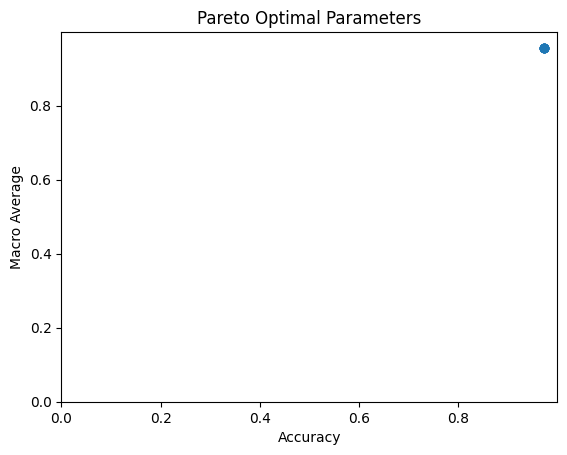

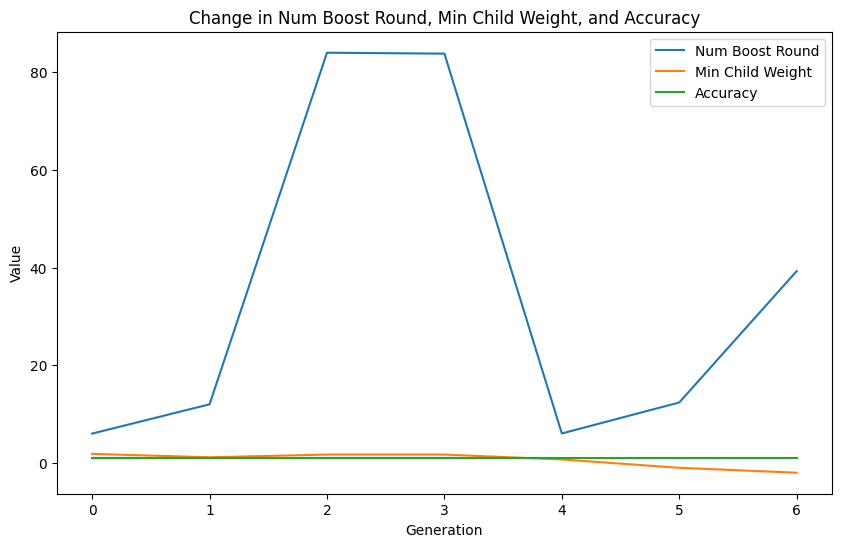

In [13]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import pandas as pd
import numpy as np

# Assuming you have a DataFrame 'df' with columns: 'WineType', 'Alcohol', 'AshAlkalinity', etc.
# Replace 'WineType' with the actual target variable and other columns with your features
df = pd.read_csv('wine.csv')
X = df.drop(columns=['ash', 'proline'])
y = df['alcohol']

# Convert the target variable to integer type
y = y.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function
def evaluate(individual):
    num_boost_round, max_depth, min_child_weight = individual
    min_child_weight = max(0.0000000001, min_child_weight)  # Ensure min_child_weight is greater than or equal to 0
    num_boost_round = int(num_boost_round)
    max_depth = max(0,int(max_depth))  # XGBoost requires integer values for these parameters
    # Define XGBoost hyperparameters
    params = {
        'objective': 'multi:softmax',  # Example: For multiclass classification
        'num_class': 178,  # Number of classes in your problem
        'booster': 'gbtree',  # 'gbtree' or 'gblinear'
        'lambda': 1,  # Regularization term
        'min_child_weight': int(min_child_weight),  # Minimum sum of instance weight (hessian) needed in a child
        'subsample': 0.8,  # Subsample ratio of the training instance
        'colsample_bylevel': 0.8,  # Subsample ratio of columns for each level
        'colsample_bytree': 0.8,  # Subsample ratio of columns for each tree
        'learning_rate': 0.1,  # Step size shrinkage to prevent overfitting
        'num_boost_round': int(num_boost_round),  # Number of boosting rounds
        'max_depth': int(max_depth),  # Maximum depth of a tree
        # Add more XGBoost parameters as needed
    }

    # ...

    min_child_weight = int(min_child_weight)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Make predictions on the test set
    y_pred = model.predict(dtest)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)

    # Calculate macro average
    report = classification_report(y_test, y_pred, output_dict=True)
    macro_avg = report['macro avg']['f1-score']

    return accuracy, macro_avg

# Define the optimization problem
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("num_boost_round", random.randint, 1, 100)
toolbox.register("max_depth", random.randint, 1, 10)
toolbox.register("min_child_weight", random.uniform, 1, 10)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.num_boost_round, toolbox.max_depth, toolbox.min_child_weight), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Run the optimization algorithm (NSGA-II)
def main():
    # Suppress runtime warnings and user warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    # Store the values of num_boost_round, min_child_weight, and accuracy
    num_boost_round_values = []
    min_child_weight_values = []
    accuracy_values = []
    pop = toolbox.population(n=14)
    algorithms.eaMuPlusLambda(pop, toolbox, mu=14, lambda_=4, cxpb=0.7, mutpb=0.2, ngen=5, stats=None, halloffame=None, verbose=True)

    # Get the best individual(s) found by NSGA-II
    best_individuals = tools.sortNondominated(pop, len(pop), first_front_only=False)[0]
    print('best set of hyperparameters',best_individuals)
    for individual in best_individuals:
            num_boost_round_values.append(individual[0])
            min_child_weight_values.append(individual[2])
            accuracy_values.append(evaluate(individual)[0])
    # Extract the hyperparameters of the best individual
    best_hyperparameters = best_individuals[0]
    best_hyperparameters = best_hyperparameters  # Assuming only one best individual, you may need to adjust if multiple
    print('best hyperparameters',best_hyperparameters)
    # Evaluate the best individual
    best_accuracy, best_macro_avg = evaluate(best_hyperparameters)

    # Print the best hyperparameters and their performance
    print("Best Hyperparameters:")
    print("Num Boost Round:", best_hyperparameters[0])
    print("Max Depth:", best_hyperparameters[1])
    print("Min Child Weight:", best_hyperparameters[2])
    print("Best Accuracy:", best_accuracy)
    print("Best Macro Average:", best_macro_avg)

    # Plot the Pareto optimal parameters
    pareto_front = np.array([indiv.fitness.values for indiv in best_individuals])

    plt.scatter(pareto_front[:, 0], pareto_front[:,1])
    plt.xlim(0, 0.999)  # Set the x-axis limits from 0 to 1
    plt.ylim(0, 0.999)  # Set the y-axis limits from 0 to 1
    plt.xlabel("Accuracy")
    plt.ylabel("Macro Average")
    plt.title("Pareto Optimal Parameters")
    plt.show()

    # Plot the change in num_boost_round, min_child_weight, and accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(num_boost_round_values, label='Num Boost Round')
    plt.plot(min_child_weight_values, label='Min Child Weight')
    plt.plot(accuracy_values, label='Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Value')
    plt.title('Change in Num Boost Round, Min Child Weight, and Accuracy')
    plt.legend()
    plt.show()

main()
